In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date
from scipy.stats import permutation_test
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pd.options.mode.chained_assignment = None
sns.set_style('dark')

In [63]:
df = pd.read_parquet('parquet/us_full_covid.parquet')
df_eur = pd.read_parquet('parquet/eur_full_covid.parquet')
df_can = pd.read_parquet('parquet/can-covid-mar2020-apr2022.parquet')

df['prediction'] = np.where(df['prediction'] == 0, -1, 1) # More intuitive sentiment score scales.
df_eur['prediction'] = np.where(df_eur['prediction'] == 0, -1, 1) # More intuitive sentiment score scales.
df_can['prediction'] = np.where(df_can['prediction'] == 0, -1, 1) # More intuitive sentiment score scales.

political_ideology = (pd.read_csv('top_30_publishers_annotate.csv')
                    .rename(columns={'Unnamed: 0': 'publisher', 'publisher': 'drop_this'})
                    .drop(columns=['drop_this', 'nuanced']))
df = df.merge(political_ideology, on='publisher', how='outer')

## Basic Data Summary

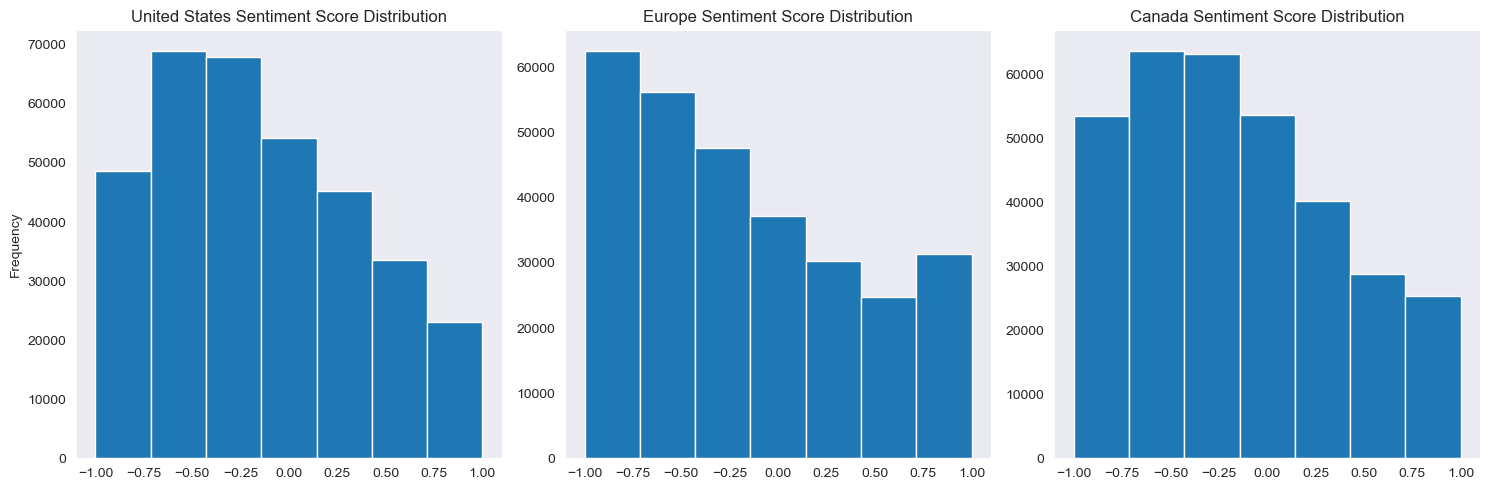

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
df.groupby('article_id')['prediction'].mean().plot.hist(bins=7, ax=axs[0])
df_eur.groupby('article_id')['prediction'].mean().plot.hist(bins=7, ax=axs[1])
df_can.groupby('article_id')['prediction'].mean().plot.hist(bins=7, ax=axs[2])
axs[0].set_title("United States Sentiment Score Distribution")
axs[1].set_title("Europe Sentiment Score Distribution")
axs[1].set_ylabel("")
axs[2].set_title("Canada Sentiment Score Distribution")
axs[2].set_ylabel("")
plt.tight_layout()

In [65]:
summary_df = pd.DataFrame({'Article Sample Size':[df['article_id'].nunique() ,df_can['article_id'].nunique(), df_eur['article_id'].nunique()],
            'Average Sentiment Score': [df['prediction'].mean() ,df_can['prediction'].mean(), df_eur['prediction'].mean()]},
            index=['United States', 'Canada', 'Europe'])
summary_df

,Article Sample Size,Average Sentiment Score
United States,341637,-0.165165
Canada,328768,-0.178574
Europe,290174,-0.204162


In [66]:
def get_sample_per_predict_block(dataframe):
    predict_block_per = []
    for predict_blocks in range(1,7):
        percent_articles_w_block = round(100 * np.sum(dataframe['article_id'].value_counts() == predict_blocks) / dataframe['article_id'].nunique(), 2)
        predict_block_per.append(percent_articles_w_block)
    return predict_block_per

us_predict_block_per = get_sample_per_predict_block(df)
eur_predict_block_per = get_sample_per_predict_block(df_eur)
can_predict_block_per = get_sample_per_predict_block(df_can)

sample_length_per_article = pd.DataFrame({'US percent sample per block':us_predict_block_per,}, index=np.arange(1,7))
sample_length_per_article['Europe percent sample per block'] = eur_predict_block_per
sample_length_per_article['Canada percent sample per block'] = can_predict_block_per
sample_length_per_article

,US percent sample per block,Europe percent sample per block,Canada percent sample per block
1,0.19,1.48,1.02
2,1.21,6.19,4.52
3,2.96,8.44,6.23
4,4.32,10.04,7.91
5,8.10,11.59,11.55
6,83.22,62.26,68.78


Ideally we would want most articles to have at least 5 prediction blocks since that would mean there were over 15 sentences to run the analysis on. Anything below 3 is suspect but accounts for only 1.5% of the data.

## Sentiment Score per Prediction Block (each block contains around 3 sentences)

In [67]:
def get_sentiment_per_block(dataframe):
    avg_sentiment_per_block = []
    for predict_blocks in range(0,6):
        sentiment_per_block = dataframe.groupby('article_id').nth(predict_blocks)['prediction'].mean()
        avg_sentiment_per_block.append(sentiment_per_block)
    return avg_sentiment_per_block

us_avg_sentiment_per_block = get_sentiment_per_block(df) 
eur_avg_sentiment_per_block = get_sentiment_per_block(df_eur) 
can_avg_sentiment_per_block = get_sentiment_per_block(df_can) 

avg_sentiment_per_block_df = pd.DataFrame({'US Average Sentiment':us_avg_sentiment_per_block,}, index=np.arange(1,7))
avg_sentiment_per_block_df['Europe Average Sentiment'] = eur_avg_sentiment_per_block
avg_sentiment_per_block_df['Canada Average Sentiment'] = can_avg_sentiment_per_block
avg_sentiment_per_block_df.index = ['Sentences 1-3', 'Sentences 4-7', 'Sentences 8-10', 'Sentences 11-14', 'Sentences 15-18', 'Last three Sentences']
avg_sentiment_per_block_df.round(3)

,US Average Sentiment,Europe Average Sentiment,Canada Average Sentiment
Sentences 1-3,-0.247,-0.305,-0.258
Sentences 4-7,-0.218,-0.242,-0.193
Sentences 8-10,-0.204,-0.199,-0.208
Sentences 11-14,-0.181,-0.184,-0.188
Sentences 15-18,-0.163,-0.182,-0.148
Last three Sentences,0.058,-0.043,-0.027


RoBERTa can only take in 500 characters at a time, so to predict the sentiment for an article it needs to be split into chunks. Based on previous literature the best way to do so was to allow for as many sentences as possible for a single prediction.
This turned out to be around 3 sentences per prediction and I did this 6 times for each article (hence 6 blocks of predictions). What this table shows is quite clear: The first 3 sentences are the most negative, followed by the next three sentences, followed by the next three and so on in a monotonically decreasing fashion. This makes sense from the demand side of view of publishers since they must "capture" their audience within the first parts of the article to keep the readers attention. By the last 3 sentences, the articles are about neutral in sentiment.

A very robust finding across all three countries with the slight exception of Canada for its senteces between 4-7 and 8-11. 

<AxesSubplot:>

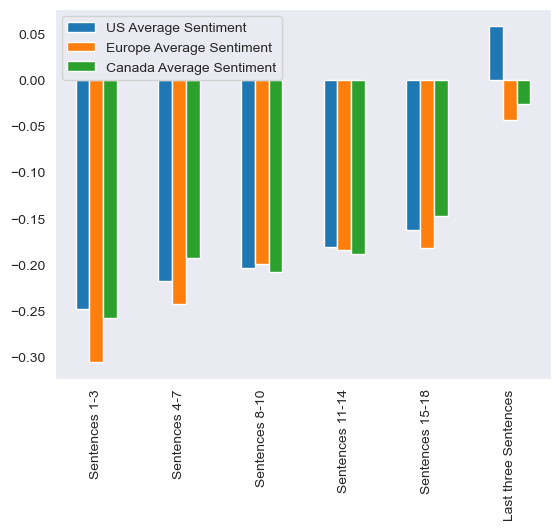

In [68]:
avg_sentiment_per_block_df.plot.bar()

In [80]:
df = df.groupby('article_id', as_index=False).nth([0,1,2,3,4])


In [84]:
df.to_csv('us_news_sentiment_bruce.csv', index=False)

## Publisher Sentiment 

Text(0.5, 1.0, 'Top 30 Most Common Publishers Average Sentiment Score')

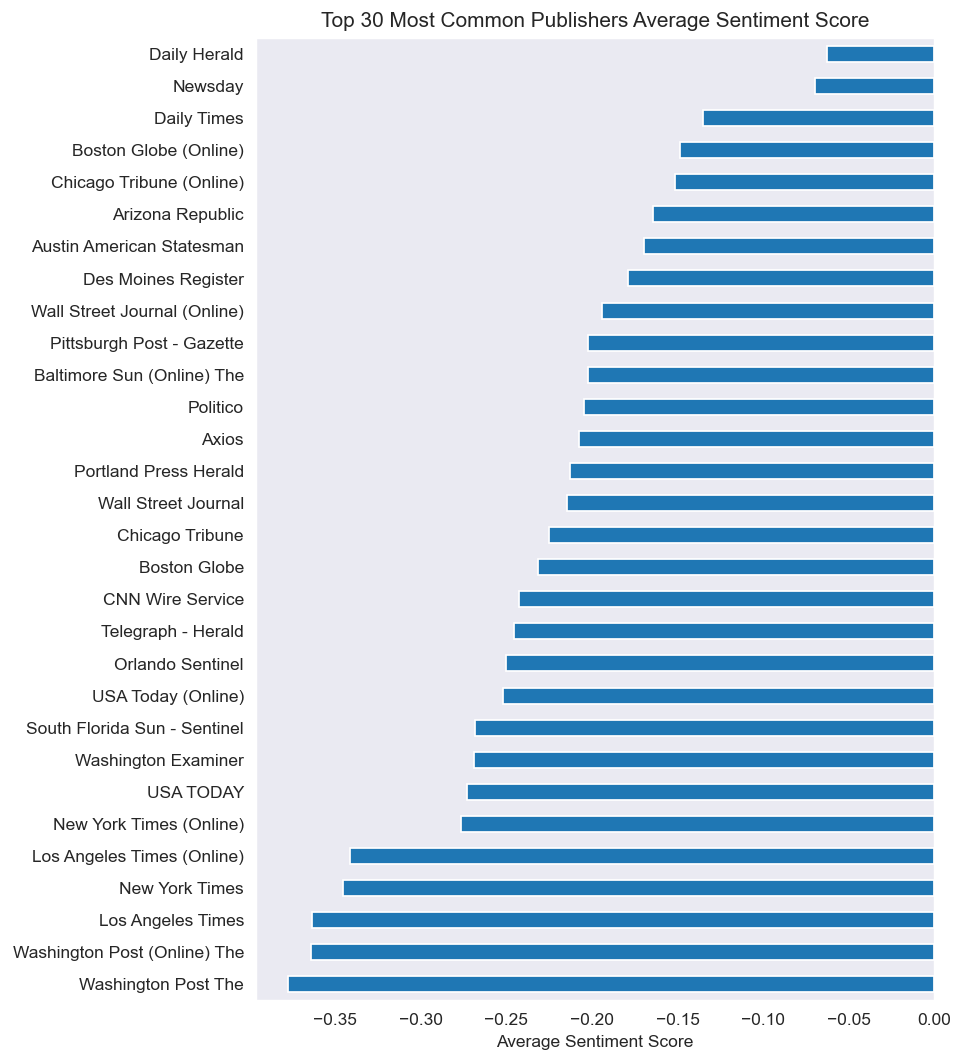

In [81]:
relevant_publishers = df['publisher'].value_counts()[:30].index
relevant_publishers_df = df.query("publisher in @relevant_publishers")
plt.figure(dpi=125, figsize=(7,10))
relevant_publishers_df.groupby("publisher")['prediction'].mean().sort_values().plot.barh()
plt.xlabel('Average Sentiment Score')
plt.ylabel('')
plt.title('Top 30 Most Common Publishers Average Sentiment Score')

Text(0.5, 1.0, 'Top 30 Most Common Publishers Average Sentiment Score')

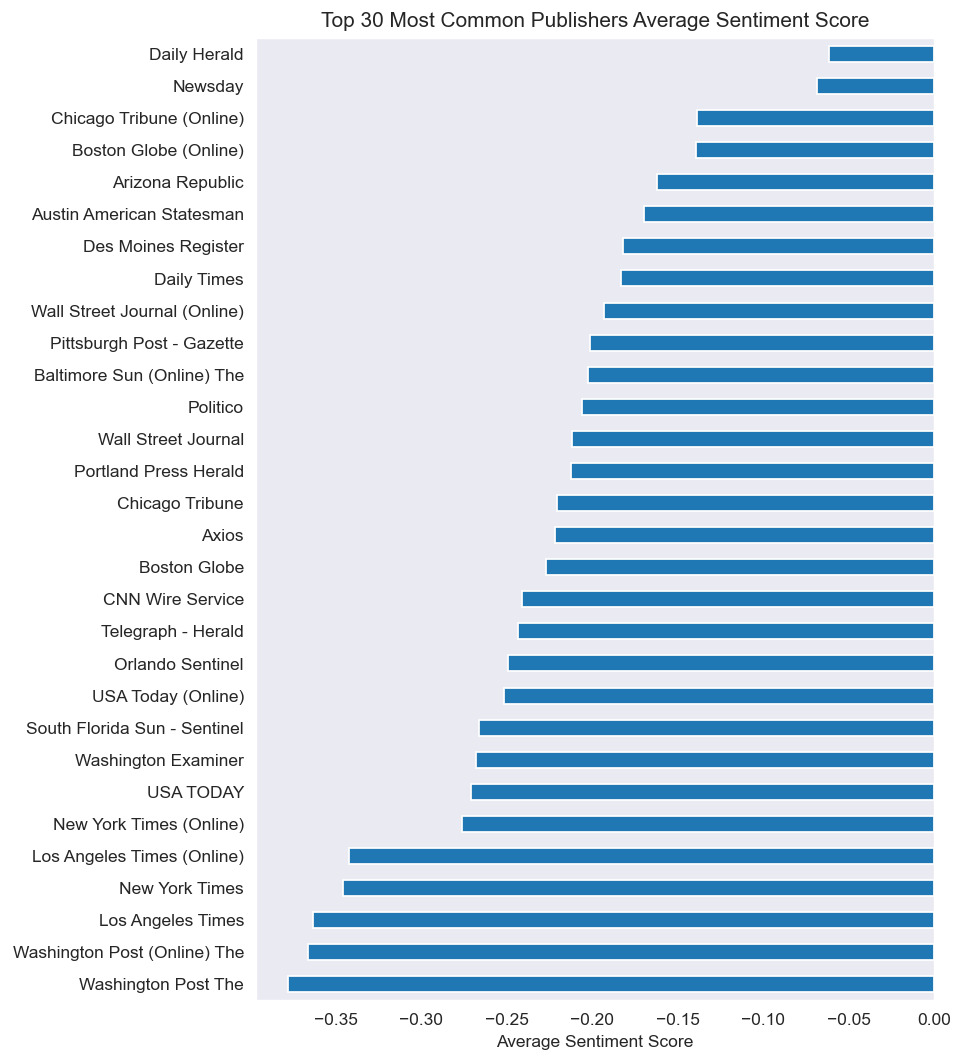

In [82]:
publisher_sentiment_per_article = relevant_publishers_df.groupby("article_id").agg({'prediction':'mean','publisher':'first'}).groupby('publisher')['prediction'].mean()
plt.figure(dpi=125, figsize=(7,10))
publisher_sentiment_per_article.sort_values().plot.barh()
plt.xlabel('Average Sentiment Score')
plt.ylabel('')
plt.title('Top 30 Most Common Publishers Average Sentiment Score')

## Page Number Analysis

In [9]:
def get_page_avg_sentiment(dataframe, country, top_n_page_samples=15):
    page_num_avg_sentiment = dataframe.groupby('page_num', as_index=False)['prediction'].mean()
    page_num_avg_sentiment_df = page_num_avg_sentiment[page_num_avg_sentiment['page_num'].isin(dataframe['page_num'].value_counts()[:top_n_page_samples].index)]
    page_num_avg_sentiment_df = page_num_avg_sentiment_df.rename(columns={'page_num':f"{country} page_num", 'prediction':f"{country} prediction"}).reset_index(drop=True)
    return page_num_avg_sentiment_df

In [10]:
avg_page_df_us = get_page_avg_sentiment(df, 'US')
avg_page_df_can = get_page_avg_sentiment(df_can, 'Canada')
avg_page_df_eur = get_page_avg_sentiment(df_eur, 'Europe')
avg_page_df = pd.concat([avg_page_df_us, avg_page_df_can, avg_page_df_eur],axis=1)
avg_page_df.round(2)

,US page_num,US prediction,Canada page_num,Canada prediction,Europe page_num,Europe prediction
0,1,-0.13,A.1,-0.15,1,-0.28
1,A.1,-0.19,A.10,-0.17,10,-0.17
2,A.2,-0.13,A.11,-0.16,12,-0.16
3,A.3,-0.13,A.2,-0.10,13,-0.21
4,A.4,-0.16,A.3,-0.13,14,-0.17
5,A.5,-0.14,A.4,-0.23,2,-0.19
6,A.6,-0.15,A.5,-0.16,3,-0.13
7,A.7,-0.18,A.6,-0.20,4,-0.21
8,A.8,-0.19,A.7,-0.18,5,-0.19
9,A.9,-0.18,A.8,-0.18,6,-0.21


In [11]:
agg_dict = {'publisher': 'first', 'page_num':'first', 'political_ideology':'first', 'country':'first','prediction':'mean'}
df['country'] = "us"
df_can['country'] = "can"
df_eur['country'] = "eur"
full_df = pd.concat([df,df_can,df_eur],axis=0, ignore_index=True)
full_df = full_df.groupby(['date','article_id'],as_index=False).agg(agg_dict)
df_eur = full_df.query('country == "eur" ').copy()
df_can = full_df.query('country == "can" ').copy()
df = full_df.query('country == "us" ').copy()

avg_page_df_us = get_page_avg_sentiment(df, 'US')
avg_page_df_can = get_page_avg_sentiment(df_can, 'Canada')
avg_page_df_eur = get_page_avg_sentiment(df_eur, 'Europe')
avg_page_df = pd.concat([avg_page_df_us, avg_page_df_can, avg_page_df_eur],axis=1)
avg_page_df.round(2)

,US page_num,US prediction,Canada page_num,Canada prediction,Europe page_num,Europe prediction
0,1,-0.13,A.1,-0.15,1,-0.30
1,A.1,-0.19,A.10,-0.17,10,-0.16
2,A.2,-0.13,A.11,-0.16,12,-0.15
3,A.3,-0.14,A.2,-0.10,13,-0.20
4,A.4,-0.16,A.3,-0.12,14,-0.17
5,A.5,-0.14,A.4,-0.22,2,-0.19
6,A.6,-0.16,A.5,-0.16,3,-0.12
7,A.7,-0.18,A.6,-0.20,4,-0.20
8,A.8,-0.19,A.7,-0.17,5,-0.18
9,A.9,-0.19,A.8,-0.18,6,-0.20


I should sort these based on relevant page numbers so Nona and n/a aren't included.

But in general there isn't a strong pattern with the exception of page 1 and page 2-3 having a clear monotonic increase in average sentiment score. I am not sure how the A page numbering works for newspapers and I'm not entirely convinced by the low sample size variance biasing the results here.

I think I should try a **permutation test** because this seems like the exact case where the null distribution has a ton of noise. 

## Articles Published per Day

In [12]:
front_page_df = full_df.query('page_num == "1" or page_num == "A.1"')

health_data_df = pd.read_parquet('parquet/cleaned_health_data.parquet')
us_front_page_df = front_page_df.query("country == 'us'")
can_front_page_df = front_page_df.query("country == 'can'")
eur_front_page_df = front_page_df.query("country == 'eur'")

us_front_page_df = us_front_page_df.merge(health_data_df.loc['United States', ['date','positive_rate']], on='date', how='inner')
can_front_page_df = can_front_page_df.merge(health_data_df.loc['Canada', ['date','positive_rate']], on='date', how='inner')
eur_front_page_df = eur_front_page_df.merge(health_data_df.loc['United Kingdom', ['date','positive_rate']], on='date', how='inner')

us_front_page_df = us_front_page_df.groupby('date').agg({'article_id':'nunique', 'positive_rate':'first', 'country':'first'}).rename(columns={'article_id':'Articles Published per Day', 'positive_rate':'Covid Positive Rate'})
can_front_page_df = can_front_page_df.groupby('date').agg({'article_id':'nunique', 'positive_rate':'first', 'country':'first'}).rename(columns={'article_id':'Articles Published per Day', 'positive_rate':'Covid Positive Rate'})
eur_front_page_df = eur_front_page_df.groupby('date').agg({'article_id':'nunique', 'positive_rate':'first', 'country':'first'}).rename(columns={'article_id':'Articles Published per Day', 'positive_rate':'Covid Positive Rate'})

us_front_page_df['Articles Published per Day'] = us_front_page_df['Articles Published per Day'].rolling(3, center=True, win_type='gaussian').mean(std=1)
can_front_page_df['Articles Published per Day'] = can_front_page_df['Articles Published per Day'].rolling(4, center=True, win_type='gaussian').mean(std=1)
eur_front_page_df['Articles Published per Day'] = eur_front_page_df['Articles Published per Day'].rolling(4, center=True, win_type='gaussian').mean(std=1)

In [13]:
front_page_df = pd.concat([us_front_page_df, can_front_page_df, eur_front_page_df]).groupby(['country', 'date']).first().reset_index(level=1)
# front_page_df.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/front_page_df.parquet')

<AxesSubplot:xlabel='date'>

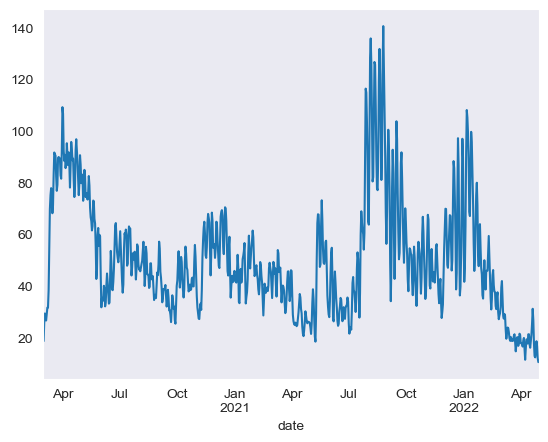

In [14]:
us_front_page_stories = df.query('page_num == "1" or page_num == "A.1"')
# us_front_page_stories.groupby('date')['article_id'].nunique().plot()
us_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()

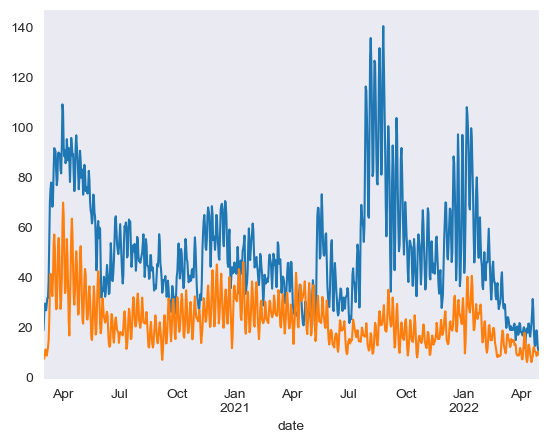

In [15]:
us_front_page_stories = df.query('page_num == "1" or page_num == "A.1"')
# us_front_page_stories.groupby('date')['article_id'].nunique().plot()
us_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()
# us_front_page_stories = df.query('page_num == "A.1"')

can_front_page_stories = df_can.query('page_num == "A.1"')
can_front_page_stories.groupby('date')['article_id'].nunique().rolling(4, center=True, win_type='gaussian').mean(std=2).plot()

eur_front_page_stories = df_eur.query('page_num == "1"')
# eur_front_page_stories.groupby('date')['article_id'].nunique().plot()
# eur_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()
# eur_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=2).plot()
# eur_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()

# notfront_page_stories = df.query('(page_num != "None") and (page_num != "n/a")')
# (front_page_stories.groupby('date')['article_id'].nunique() / notfront_page_stories.groupby('date')['article_id'].nunique()).plot()

<AxesSubplot:xlabel='date'>

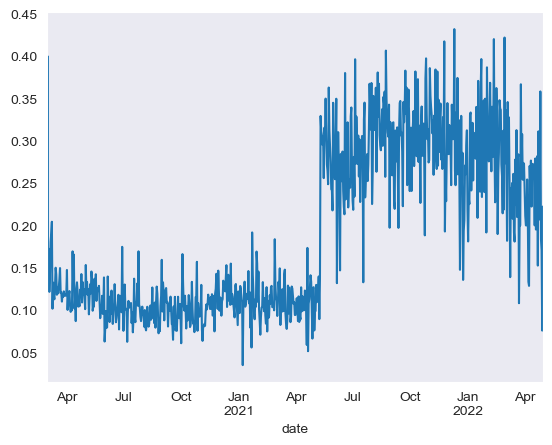

In [16]:
us_front_page_stories = df.query('page_num == "A.1"')
notfront_page_stories = df.query('(page_num != "None") and (page_num != "n/a")')
(us_front_page_stories.groupby('date')['article_id'].nunique() / notfront_page_stories.groupby('date')['article_id'].nunique()).plot()

It appears that ProQuest has a change in scraping around april where the majority of articles are front page articles. Not sure why this happens. I could supplement this story by just checking headlines and how often a headline mentions "Covid".

## Sentiment Analysis by Political Affiliation

In [17]:
us_political_df = df.dropna(subset='political_ideology')
df.groupby('political_ideology')['prediction'].mean()

political_ideology
C   -0.154393
L   -0.228938
R   -0.130079
Name: prediction, dtype: float64

<AxesSubplot:xlabel='date'>

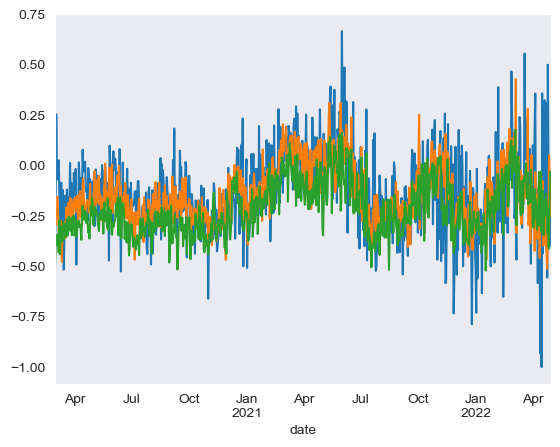

In [18]:
us_political_df.query('political_ideology == "R"').groupby('date')['prediction'].mean().plot()
us_political_df.query('political_ideology == "C"').groupby('date')['prediction'].mean().plot()
us_political_df.query('political_ideology == "L"').groupby('date')['prediction'].mean().plot()
# plt.legend()

In [19]:
us_political_df = us_political_df.groupby(['political_ideology', 'date'])['prediction'].mean().reset_index(level=1)
# us_political_df.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/us_political_sentiment.parquet')

In [20]:
smoothed_c = us_political_df.loc['C']['prediction'].rolling(3,center=True).mean()
smoothed_r = us_political_df.loc['R']['prediction'].rolling(3,center=True).mean()
smoothed_l = us_political_df.loc['L']['prediction'].rolling(3,center=True).mean()

smoothed_pred = pd.concat([smoothed_c, smoothed_r, smoothed_l]).reset_index(drop=True)

# pd.concat([us_political_df, smoothed_pred], axis=1)

In [21]:
us_political_df['smoothed_pred'] = smoothed_pred

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_political_df.loc['R', 'date'], y=us_political_df.loc['R', 'prediction'], name='Republican', line={'color':'#fc2626'}, opacity=0.9))
fig.add_trace(go.Scatter(x=us_political_df.loc['L', 'date'], y=us_political_df.loc['L', 'prediction'], name='Liberal', line={'color':'#585fcc'}, opacity=0.9))
fig.add_trace(go.Scatter(x=us_political_df.loc['C', 'date'], y=us_political_df.loc['C', 'prediction'], name='Moderate',))
fig.update_yaxes(title_text="Sentiment Score")

## Sentiment Score Graphs

In [23]:
df = df.groupby('date', as_index=False).agg(agg_dict)
df_eur = df_eur.groupby('date', as_index=False).agg(agg_dict)
df_can = df_can.groupby('date', as_index=False).agg(agg_dict)

df['smoothed_prediction'] = df.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)
df_eur['smoothed_prediction'] = df_eur.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)
df_can['smoothed_prediction'] = df_can.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)

health_data_df = pd.read_parquet('parquet/cleaned_health_data.parquet')

df = df.merge(health_data_df.loc['United States'], on='date', how='inner')
df_can = df_can.merge(health_data_df.loc['Canada'], on='date', how='inner')
df_eur = df_eur.merge(health_data_df.loc['United Kingdom'], on='date', how='inner')

In [24]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df['date'], y=df['smoothed_prediction'], name="Sentiment Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['date'], y=df['positive_rate'], name="Covid Positive Rate"),
    secondary_y=True, 
)

**TIMELINE Slope Checks**

- April 5th 2020 - June 10 2020
- June 10 2020 - July 7th 2020
- January 1 - March 15th
- April 15th - June 10th
- June 11th - August 10th (delta)
- August 25th - Nov 1st (end of delta)
- Nov 3rd - Jan 10th (omicron)
- Jan 11th - Mar 15th (after omicron)

In [25]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_can['date'], y=df_can['smoothed_prediction'], name="Sentiment Score"), secondary_y=False)
    
fig.add_trace(
    go.Scatter(x=df_can['date'], y=df_can['positive_rate'], name="Covid Positive Rate"), secondary_y=True,)

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["date"], y=df["prediction"], name="US", mode="lines"))
fig.add_trace(go.Scatter(x=df_can["date"], y=df_can["prediction"], name="Can", mode="lines"))
fig.add_trace(go.Scatter(x=df_eur["date"], y=df_eur["prediction"], name="eur", mode="lines"))

fig.update_layout(
    title="Comparing Sentiment Scores Across Countries", xaxis_title="Date", yaxis_title="Close"
)

## Regression Analysis

/opt/homebrew/Caskroom/miniforge/base/envs/clinic/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



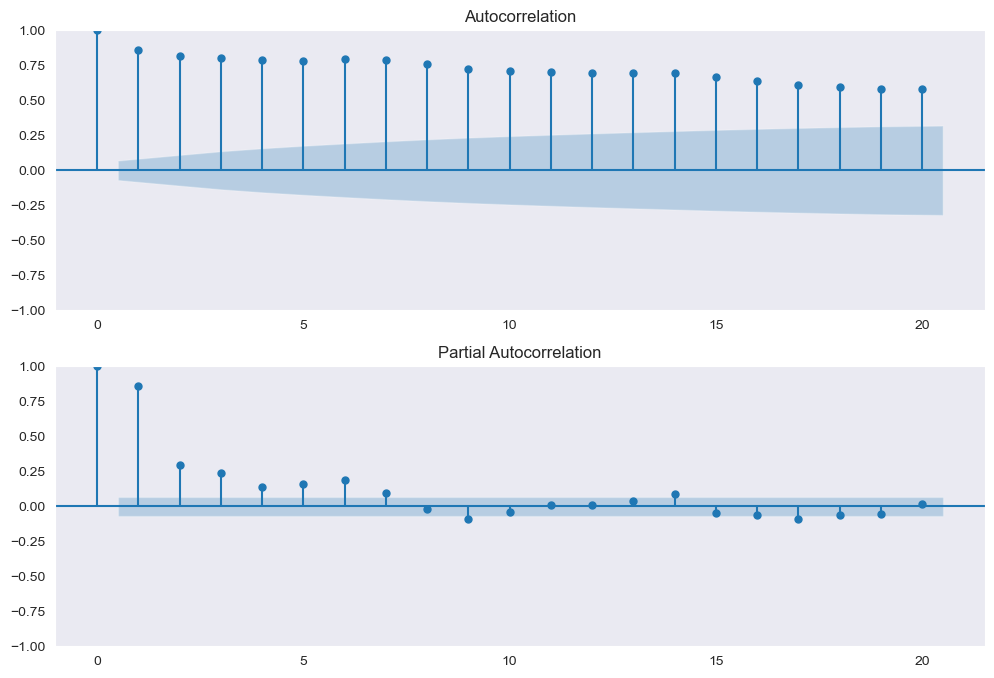

In [73]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

adfuller(df['prediction'].dropna())
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['prediction'].iloc[0:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['prediction'].iloc[0:],lags=20,ax=ax2)

In [74]:
df_subset = df.dropna(subset='positive_rate').reset_index(drop=True)
# model= ARIMA(df_subset['positive_rate'], df_subset['prediction'], order=(1,1,1))
model= ARIMA(df_subset['prediction'], df_subset['positive_rate'], order=(2,1,1))
model= ARIMA(df_subset['smoothed_prediction'], df_subset['positive_rate'], order=(2,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     smoothed_prediction   No. Observations:                  785
Model:                  ARIMA(2, 1, 1)   Log Likelihood                2031.981
Date:                 Thu, 22 Dec 2022   AIC                          -4053.962
Time:                         16:11:30   BIC                          -4030.640
Sample:                              0   HQIC                         -4044.994
                                 - 785                                         
Covariance Type:                   opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
positive_rate    -0.4736      0.247     -1.921      0.055      -0.957       0.010
ar.L1             0.4489      0.040     11.097      0.000       0.370       0.528
ar.L2            -0.5029      0.032    -15.644      0.000      -0.566      -0.440
ma.L1             0.4331      0.042     10.197      0.000       0.350       0.516
sigma2            0.0003   1.28e-05     25.424      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                60.68
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.18   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**TIMELINE Slope Checks**

- April 5th 2020 - June 10 2020
- June 10 2020 - July 7th 2020
- January 1 - March 15th
- April 15th - June 10th
- June 11th - August 10th (delta)
- August 25th - Nov 1st (end of delta)
- Nov 3rd - Jan 10th (omicron)
- Jan 11th - Mar 15th (after omicron)

In [75]:
slope_estimates = {}

def calculate_sentiment_slope(sentiment_prediction_array):
    date = np.arange(len(sentiment_prediction_array))
    slope = round(np.polyfit(date,sentiment_prediction_array,1)[0],5)
    return slope

first_wave_decline = df.query('date >= "2020-04-05" and date <= "2020-06-10"')['smoothed_prediction']
first_wave_increase = df.query('date >= "2020-06-10" and date <= "2020-07-07"')['smoothed_prediction']
slope_estimates['first_wave_decline'] = calculate_sentiment_slope(first_wave_decline)
slope_estimates['first_wave_increase'] = calculate_sentiment_slope(first_wave_increase)

first_summer_decline = df.query('date >= "2021-01-01" and date <= "2021-03-15"')['smoothed_prediction']
second_summer_decline = df.query('date >= "2021-04-15" and date <= "2021-06-10"')['smoothed_prediction']
slope_estimates['first_summer_decline'] = calculate_sentiment_slope(first_summer_decline)
slope_estimates['second_summer_decline'] = calculate_sentiment_slope(second_summer_decline)

delta_wave = df.query('date >= "2021-06-11" and date <= "2021-08-10"')['smoothed_prediction']
end_delta_wave = df.query('date >= "2021-08-25" and date <= "2021-11-01"')['smoothed_prediction']
slope_estimates['delta_wave'] = calculate_sentiment_slope(delta_wave)
slope_estimates['end_delta_wave'] = calculate_sentiment_slope(end_delta_wave)

omicron_wave = df.query('date >= "2021-11-01" and date < "2022-01-10"')['smoothed_prediction']
after_omicron_wave = df.query('date >= "2021-01-10" and date <= "2022-03-15"')['smoothed_prediction']
slope_estimates['omicron_wave'] = calculate_sentiment_slope(omicron_wave)
slope_estimates['after_omicron_wave'] = calculate_sentiment_slope(after_omicron_wave)

In [76]:
pd.DataFrame(pd.Series(slope_estimates, name='slope_estimates'))

,slope_estimates
first_wave_decline,0.00091
first_wave_increase,-0.00618
first_summer_decline,0.00375
second_summer_decline,0.00292
delta_wave,-0.00622
end_delta_wave,0.00414
omicron_wave,-0.00394
after_omicron_wave,-0.00038


## Can The Op-ed Article sentiment trend be explained by low sample size?

To test for this we can use a few methods. The main method will be sampling from the original dataframe and then computing the slope estimates during the important time periods. If the low sample size is robust enough to reproduce the slopes from the full dataset, then this indicates that the low sample size op-ed dataset is reliable enough to make slope estimates.

In [315]:
df = pd.read_parquet('parquet/us_full_covid.parquet')
df['prediction'] = np.where(df['prediction'] == 0, -1, 1) # More intuitive sentiment score scales.
political_ideology = (pd.read_csv('top_30_publishers_annotate.csv')
                    .rename(columns={'Unnamed: 0': 'publisher', 'publisher': 'drop_this'})
                    .drop(columns=['drop_this', 'nuanced']))
df = df.merge(political_ideology, on='publisher', how='outer')

df_oped = df.query("is_oped == True")
df_non_oped = df.query("is_oped == False")

oped_article_samples_per_day = df_oped.groupby('date', as_index=True)['article_id'].nunique()

def simulate_oped_sample_trend():
    sample_sentiment_per_day = []
    for date, num_oped_articles_on_day in oped_article_samples_per_day.items():
        average_sentiment_individual_articles = df_non_oped.query("date == @date").groupby('article_id')['prediction'].mean()
        average_sentiment_individual_articles = average_sentiment_individual_articles.sample(n=num_oped_articles_on_day)
        sample_sentiment_per_day.append(average_sentiment_individual_articles.mean())
    return sample_sentiment_per_day

df_non_oped_grouped = df_non_oped.groupby('date', as_index=False)['prediction'].mean()
df_non_oped_grouped['smoothed_prediction'] = df_non_oped_grouped.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)
df_oped_grouped = df_oped.groupby('date', as_index=False)['prediction'].mean()
df_oped_grouped['smoothed_prediction'] = df_oped_grouped.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)

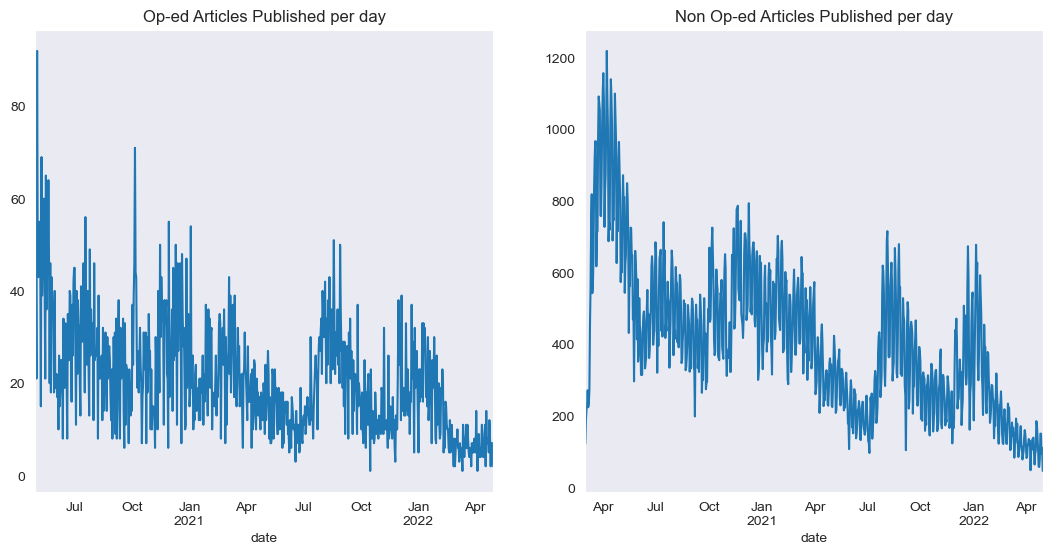

In [316]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
df_oped.groupby('date')['article_id'].nunique().plot(ax=axes[0], title='Op-ed Articles Published per day')
df_non_oped.groupby('date')['article_id'].nunique().plot(ax=axes[1], title='Non Op-ed Articles Published per day');

<AxesSubplot: >

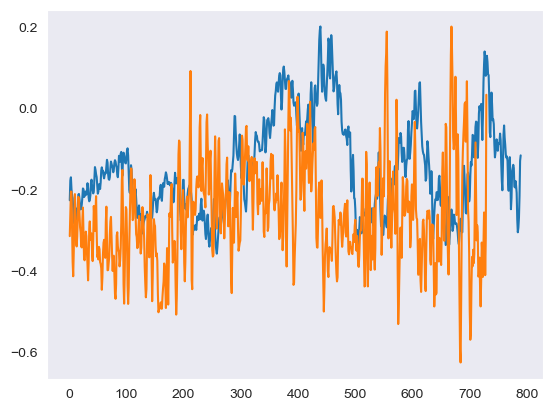

In [318]:
df_non_oped_grouped['smoothed_prediction'].plot()
df_oped_grouped['smoothed_prediction'].plot()

In [317]:
list_sample_sentiment_per_day = []
simulated_date_index = oped_article_samples_per_day.index
for i in range(10):
    simulate_sentiment_oped = pd.Series(simulate_oped_sample_trend(), index=simulated_date_index, name='smoothed_prediction')
    list_sample_sentiment_per_day.append(simulate_sentiment_oped.rolling(window=3, center=True, win_type="gaussian").mean(std=1))

In [377]:
def calculate_sentiment_slope(sentiment_prediction_array):
    date = np.arange(len(sentiment_prediction_array))
    slope = round(np.polyfit(date,sentiment_prediction_array,1)[0],5)
    return slope

def get_slope_and_level_estimates(dataframe):
    slope_estimates = {}
    level_estimates = {}
    # first_wave_decline = dataframe.query('date >= "2020-04-05" and date <= "2020-06-10"')['smoothed_prediction'] # edited the date
    first_wave_decline = dataframe.query('date >= "2020-05-01" and date <= "2020-06-09"')['smoothed_prediction'] # edited the date
    slope_estimates['semi_first_wave_decline'] = calculate_sentiment_slope(first_wave_decline)
    level_estimates['semi_first_wave_decline_peak'] = first_wave_decline.iloc[0]
    level_estimates['semi_first_wave_decline_min'] = first_wave_decline.iloc[-1]

    first_wave_increase = dataframe.query('date >= "2020-06-10" and date <= "2020-07-07"')['smoothed_prediction']
    slope_estimates['first_wave_increase'] = calculate_sentiment_slope(first_wave_increase)
    level_estimates['first_wave_increase_min'] = first_wave_increase.iloc[0]
    level_estimates['first_wave_increase_peak'] = first_wave_increase.iloc[-1]

    second_wave_decline = dataframe.query('date >= "2020-07-11" and date <= "2020-09-25"')['smoothed_prediction'] # edited the date
    slope_estimates['second_wave_decline'] = calculate_sentiment_slope(second_wave_decline)
    level_estimates['second_wave_peak'] = second_wave_decline.iloc[0]
    level_estimates['second_wave_end'] = second_wave_decline.iloc[-1]

    first_summer_decline = dataframe.query('date >= "2021-01-02" and date <= "2021-03-15"')['smoothed_prediction']
    slope_estimates['first_summer_decline'] = calculate_sentiment_slope(first_summer_decline)
    level_estimates['first_summer_decline_peak'] = first_summer_decline.iloc[0]
    level_estimates['first_summer_decline_end'] = first_summer_decline.iloc[-1]

    second_summer_decline = dataframe.query('date >= "2021-04-13" and date <= "2021-06-10"')['smoothed_prediction']
    slope_estimates['second_summer_decline'] = calculate_sentiment_slope(second_summer_decline)
    level_estimates['second_summer_decline_peak'] = second_summer_decline.iloc[0]
    level_estimates['second_summer_decline_end'] = second_summer_decline.iloc[-1]

    delta_wave = dataframe.query('date >= "2021-06-11" and date <= "2021-08-10"')['smoothed_prediction']
    slope_estimates['start_delta_wave'] = calculate_sentiment_slope(delta_wave)
    level_estimates['start_delta_wave_peak'] = delta_wave.iloc[-1]
    level_estimates['start_delta_wave_min'] = delta_wave.iloc[0]

    end_delta_wave = dataframe.query('date >= "2021-08-25" and date <= "2021-11-01"')['smoothed_prediction']
    slope_estimates['end_delta_wave'] = calculate_sentiment_slope(end_delta_wave)
    level_estimates['end_delta_wave_peak'] = end_delta_wave.iloc[0]
    level_estimates['end_delta_wave_min'] = end_delta_wave.iloc[-1]
    
    omicron_wave = dataframe.query('date >= "2021-11-01" and date <= "2022-01-07"')['smoothed_prediction']
    slope_estimates['start_omicron_wave'] = calculate_sentiment_slope(omicron_wave)
    level_estimates['start_omicron_wave_min'] = omicron_wave.iloc[0]
    level_estimates['start_omicron_wave_peak'] = omicron_wave.iloc[-1]

    after_omicron_wave = dataframe.query('date >= "2021-01-08" and date <= "2022-03-15"')['smoothed_prediction']
    slope_estimates['end_omicron_wave'] = calculate_sentiment_slope(after_omicron_wave)
    level_estimates['after_omicron_wave_peak'] = after_omicron_wave.iloc[0]
    level_estimates['after_omicron_wave_min'] = after_omicron_wave.iloc[-1]

    return slope_estimates, level_estimates

**add in level difference with sentiment score from the peaks of each of graph**

In [378]:
slope_estimates_true_dataframe_nonoped, level_estimates_true_dataframe_nonoped = get_slope_and_level_estimates(df_non_oped_grouped)
slope_estimates_opeds, level_estimates_oped = get_slope_and_level_estimates(df_oped_grouped)
comparison_df_slopes = pd.DataFrame([slope_estimates_opeds, slope_estimates_true_dataframe_nonoped, ], index=['oped slopes', 'non_oped slopes']).T
comparison_df_slopes['oped_slope vs non-oped slope'] = comparison_df_slopes['oped slopes'] / comparison_df_slopes['non_oped slopes']
comparison_df_slopes = comparison_df_slopes.round(2)

comparison_df_level = pd.DataFrame([level_estimates_oped, level_estimates_true_dataframe_nonoped, ], index=['oped level', 'non_oped level']).T
comparison_df_level['oped_level - non-oped_level'] = comparison_df_level['oped level'] - comparison_df_level['non_oped level']
comparison_df_level = comparison_df_level.round(2)


In [379]:
comparison_df_level

,oped level,non_oped level,oped_level - non-oped_level
semi_first_wave_decline_peak,-0.31,-0.17,-0.14
semi_first_wave_decline_min,-0.35,-0.12,-0.23
first_wave_increase_min,-0.38,-0.10,-0.27
first_wave_increase_peak,-0.40,-0.31,-0.09
second_wave_peak,-0.28,-0.27,-0.01
second_wave_end,-0.27,-0.20,-0.07
first_summer_decline_peak,-0.10,-0.23,0.13
first_summer_decline_end,-0.12,0.05,-0.17
second_summer_decline_peak,-0.29,-0.08,-0.22
second_summer_decline_end,-0.18,0.08,-0.27


During the first semi wave decline the op-ed articles surprisingly became **more** negative while the regular news became more positive as cases decreased.

First Wave: op-ed articles only become slightly more negative while non oped articles become *much* more negative (it is interesting that oped articles fail to become more negative).

Second Wave: Once again oped articles fail to get more positive even with the decrease in Covid Cases while the regular news goes from -0.27 to -0.20.

First Summer Decline: Interestingly oped articles become more negative with the decline in cases, while the regular articles finally just barely become more positive than negative.

Second Summer Decline: This is the first wave where both oped articles and regular news articles move in the same direction and at the same level amount. Although this is when the news is publishing the least number of articles!

start_delta_wave: Both oped and regular news articles become more positive however oped articles are still mostly negative while regular news articles are at their most positive.

end_delta_wave: oped articles fail to become more positive while regular news articles do.

start_omicron_wave: oped articles become 0.12 more negative while regular news becomes 0.27 more negative, a huge jump.

after_omicron_wave: Interestingly oped articles become much more negative during the decline in omicron cases! even more negative than at the peak of the wave. while regular news articles only become slightly more positive. 

In [312]:
# slope_estimates_simulation_nonoped = get_slope_estimates(list_sample_sentiment_per_day[2].reset_index())

|                       |   slope_estimates |
|:----------------------|------------------:|
| first_wave_decline    |           0.00091 |
| first_wave_increase   |          -0.00618 |
| first_summer_decline  |           0.00375 |
| second_summer_decline |           0.00292 |
| delta_wave            |          -0.00622 |
| end_delta_wave        |           0.00414 |
| omicron_wave          |          -0.00394 |
| after_omicron_wave    |          -0.00038 |


In [287]:
slope_estimates_true_dataframe_nonoped

{'first_wave_decline': 0.00124,
 'first_wave_increase': -0.00627,
 'first_summer_decline': 0.0038,
 'second_summer_decline': 0.00306,
 'delta_wave': -0.00622,
 'end_delta_wave': 0.00423,
 'omicron_wave': -0.00401,
 'after_omicron_wave': -0.00039}

In [356]:
smoothed_bootstrap = pd.Series(list_sample_sentiment_per_day[0], index=oped_article_samples_per_day.index, name='bootstrap').rolling(4, center=True, win_type='gaussian',).mean(std=2)
smoothed_bootstrap_two = pd.Series(list_sample_sentiment_per_day[1], index=oped_article_samples_per_day.index, name='bootstrap').rolling(4, center=True, win_type='gaussian',).mean(std=2)
smoothed_bootstrap_three = pd.Series(list_sample_sentiment_per_day[2], index=oped_article_samples_per_day.index, name='bootstrap').rolling(4, center=True, win_type='gaussian',).mean(std=2)
pd.DataFrame([smoothed_bootstrap, smoothed_bootstrap_two, smoothed_bootstrap_three]).T.corr()

,bootstrap,bootstrap,bootstrap
bootstrap,1.000000,0.762966,0.753656
bootstrap,0.762966,1.000000,0.717740
bootstrap,0.753656,0.717740,1.000000


In [357]:
big = [pd.Series(sample_sentiment_per_day, index=oped_article_samples_per_day.index, name=f'bootstrap_{k}').rolling(4, center=True, win_type='gaussian',).mean(std=2) for k, sample_sentiment_per_day in enumerate(list_sample_sentiment_per_day)]
pd.DataFrame(big).T.corr()

,bootstrap_0,bootstrap_1,bootstrap_2,bootstrap_3,bootstrap_4,bootstrap_5,bootstrap_6,bootstrap_7,bootstrap_8,bootstrap_9
bootstrap_0,1.000000,0.762966,0.753656,0.726861,0.786128,0.746682,0.739872,0.721769,0.752759,0.737171
bootstrap_1,0.762966,1.000000,0.717740,0.726649,0.750912,0.716254,0.706654,0.739959,0.774094,0.703205
bootstrap_2,0.753656,0.717740,1.000000,0.706062,0.711189,0.712576,0.742829,0.771336,0.743113,0.780845
bootstrap_3,0.726861,0.726649,0.706062,1.000000,0.706036,0.779329,0.747582,0.723487,0.759730,0.768922
bootstrap_4,0.786128,0.750912,0.711189,0.706036,1.000000,0.774981,0.768708,0.730727,0.804947,0.761140
bootstrap_5,0.746682,0.716254,0.712576,0.779329,0.774981,1.000000,0.736778,0.716289,0.784886,0.770769
bootstrap_6,0.739872,0.706654,0.742829,0.747582,0.768708,0.736778,1.000000,0.751460,0.772037,0.753993
bootstrap_7,0.721769,0.739959,0.771336,0.723487,0.730727,0.716289,0.751460,1.000000,0.776064,0.763378
bootstrap_8,0.752759,0.774094,0.743113,0.759730,0.804947,0.784886,0.772037,0.776064,1.000000,0.760286
bootstrap_9,0.737171,0.703205,0.780845,0.768922,0.761140,0.770769,0.753993,0.763378,0.760286,1.000000


In [358]:
[pd.Series(sample_sentiment_per_day, index=oped_article_samples_per_day.index, name='bootstrap').rolling(4, center=True, win_type='gaussian',).mean(std=2) for sample_sentiment_per_day in list_sample_sentiment_per_day]

[date
 2020-04-30         NaN
 2020-05-01         NaN
 2020-05-02         NaN
 2020-05-03   -0.158161
 2020-05-04   -0.181948
                 ...   
 2022-04-26   -0.363096
 2022-04-27   -0.257615
 2022-04-28   -0.183710
 2022-04-29         NaN
 2022-04-30         NaN
 Name: bootstrap, Length: 731, dtype: float64,
 date
 2020-04-30         NaN
 2020-05-01         NaN
 2020-05-02         NaN
 2020-05-03   -0.169403
 2020-05-04   -0.163660
                 ...   
 2022-04-26   -0.361184
 2022-04-27   -0.299576
 2022-04-28   -0.175824
 2022-04-29         NaN
 2022-04-30         NaN
 Name: bootstrap, Length: 731, dtype: float64,
 date
 2020-04-30         NaN
 2020-05-01         NaN
 2020-05-02         NaN
 2020-05-03   -0.189676
 2020-05-04   -0.198291
                 ...   
 2022-04-26   -0.172470
 2022-04-27   -0.035594
 2022-04-28    0.057077
 2022-04-29         NaN
 2022-04-30         NaN
 Name: bootstrap, Length: 731, dtype: float64,
 date
 2020-04-30         NaN
 2020-05-01        

In [360]:
df_oped_comparison = df_non_oped_plot.join(smoothed_bootstrap, how='right').dropna()

<AxesSubplot: xlabel='date'>

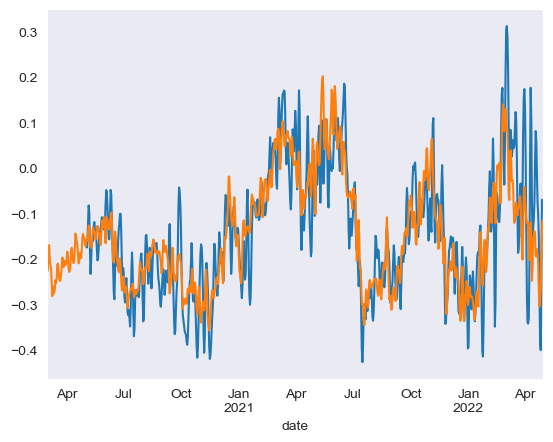

In [361]:
pd.Series(list_sample_sentiment_per_day[1], index=oped_article_samples_per_day.index).rolling(3, center=True, win_type='gaussian').mean(std=1).plot()
df_non_oped_plot['smoothed_prediction'].plot(label='non-oped-true')

# Other

In [64]:
# df = df.merge(us_articles_published_per_day, on='date')
# df_eur = df_eur.merge(eur_articles_published_per_day, on='date')
# df_can = df_can.merge(can_articles_published_per_day, on='date')

# df = df.rename(columns={'positive_rate': 'Covid Positive Rate', 'smoothed_prediction':'Sentiment Score'})
# df_eur = df_eur.rename(columns={'positive_rate': 'Covid Positive Rate', 'smoothed_prediction':'Sentiment Score'})
# df_can = df_can.rename(columns={'positive_rate': 'Covid Positive Rate', 'smoothed_prediction':'Sentiment Score'})

# df.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/us_covid_dash.parquet')
# df_eur.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/eur_covid_dash.parquet')
# df_can.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/can_covid_dash.parquet')